In [22]:
!date

Wed Apr  2 21:55:36 EDT 2025


In [23]:
pwd

'/mmfs1/data/aglinska/BC-ABCD-denoise/Code'

In [24]:
%%time
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel.processing as nibp
from scipy import signal
from itertools import combinations_with_replacement
from numpy import savetxt
import nibabel as nib
import math
from numpy import random
import sklearn.preprocessing  
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from typing import List, Callable, Union, Any, TypeVar, Tuple
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn import linear_model

CPU times: user 97 µs, sys: 10 µs, total: 107 µs
Wall time: 120 µs


In [25]:
%%time
import ants # ANTSpy in the toolbox for manipulating MRI files 
from tqdm import tqdm # Easy progress bars
import seaborn as sns

CPU times: user 25 µs, sys: 0 ns, total: 25 µs
Wall time: 36.7 µs


CPU times: user 1.15 s, sys: 380 ms, total: 1.53 s
Wall time: 1.56 s


In [26]:
import sys
from IPython import display
import pickle

## Defining CVAE model and helper functions 

In [27]:
def correlation(x,y):
  x_mean = np.repeat(x.mean(),x.shape,axis=0)
  y_mean = np.repeat(y.mean(),y.shape,axis=0)
  cov = (x-x_mean)*(y-y_mean)
  r = cov.sum()/(x.std()*y.std()*x.shape[0])
  return r

def remove_std0(arr):
    std0 = np.argwhere(np.std(arr, axis=1) == 0.0)
    arr_o = np.delete(arr,std0 ,axis=0) 
    return arr_o

def compute_in(x):
  return (x-3)/2+1

def compute_in_size(x):
  for i in range(4):
    x = compute_in(x)
  return x

def compute_out_size(x):
  return ((((x*2+1)*2+1)*2+1)*2+1)

def compute_padding(x):
  rounding = np.ceil(compute_in_size(x))-compute_in_size(x)
  y = ((((rounding*2)*2)*2)*2)
  pad = bin(int(y)).replace('0b', '')
  if len(pad) < 4:
      for i in range(4-len(pad)):
          pad = '0' + pad
  final_size = compute_in_size(x+y)
  pad_out = bin(int(compute_out_size(final_size)-x)).replace('0b','')
  if len(pad_out) < 4:
      for i in range(4-len(pad_out)):
          pad_out = '0' + pad_out
  return pad,final_size, pad_out

In [28]:
class TrainDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Y):
    self.obs = X
    self.noi = Y

  def __len__(self):
    return min(self.obs.shape[0],self.noi.shape[0])

  def __getitem__(self, index):
    observation = self.obs[index]
    noise = self.noi[index]
    s = 2*random.beta(4,4,1)
    noise_aug = s*noise
    return observation, noise_aug

In [29]:
class cVAE(nn.Module):

    def __init__(self,conf,in_channels: int,in_dim: int, latent_dim: tuple,hidden_dims: List = None, beta : float = 1, gamma : float = 1, delta : float = 1, scale_MSE_GM : float = 1, scale_MSE_CF : float = 1, scale_MSE_FG : float = 1,do_disentangle = True, freq_exp : float = 1, freq_scale : float = 1) -> None:
        super(cVAE, self).__init__()

        self.latent_dim = latent_dim
        self.latent_dim_z = self.latent_dim[0]
        self.latent_dim_s = self.latent_dim[1]
        self.in_channels = in_channels
        self.in_dim = in_dim
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.scale_MSE_GM = scale_MSE_GM
        self.scale_MSE_CF = scale_MSE_CF
        self.do_disentangle = do_disentangle
        self.freq_exp = freq_exp
        self.freq_scale = freq_scale
        self.scale_MSE_FG = scale_MSE_FG
        self.confounds = conf.float()
        self.grl = GradientReversalLayer(lambda_=1.0)

        self.decoder_confounds_z = nn.Sequential(
        
                nn.ConvTranspose1d(in_channels=latent_dim[0], out_channels=128, 
                                   kernel_size=nTR, stride=1, bias=False),
            
                # First conv layer: convert 128 channels to 32 channels.
                nn.Conv1d(in_channels=128, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False),
                nn.ReLU(),
            
                # Second conv layer: convert 32 channels to 16 channels.
                nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False),
                nn.ReLU(),
            
                # Third conv layer: convert 16 channels to 6 channels.
                nn.Conv1d(in_channels=16, out_channels=6, kernel_size=3, stride=1, padding=1, bias=False),
                nn.Sigmoid()  # Normalize the output to [0, 1]
                    )


        self.decoder_confounds_s = nn.Sequential(
        
                nn.ConvTranspose1d(in_channels=latent_dim[1], out_channels=128, 
                                   kernel_size=nTR, stride=1, bias=False),
            
                # First conv layer: convert 128 channels to 32 channels.
                nn.Conv1d(in_channels=128, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False),
                nn.ReLU(),
            
                # Second conv layer: convert 32 channels to 16 channels.
                nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False),
                nn.ReLU(),
            
                # Third conv layer: convert 16 channels to 6 channels.
                nn.Conv1d(in_channels=16, out_channels=6, kernel_size=3, stride=1, padding=1, bias=False),
                nn.Sigmoid()  # Normalize the output to [0, 1]
                    )

    

        modules_z = []
        if hidden_dims is None:
            hidden_dims = [64, 128, 256, 256]
        
        self.pad, self.final_size, self.pad_out = compute_padding(self.in_dim)

        # Build Encoder
        for i in range(len(hidden_dims)):
            h_dim = hidden_dims[i]
            modules_z.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = int(self.pad[-i-1])),
                    nn.LeakyReLU()
                    )
            )
            in_channels = h_dim

        self.encoder_z = nn.Sequential(*modules_z)
        self.fc_mu_z = nn.Linear(hidden_dims[-1]*int(self.final_size), self.latent_dim_z)
        self.fc_var_z = nn.Linear(hidden_dims[-1]*int(self.final_size), self.latent_dim_z)

        modules_s = []
        in_channels = self.in_channels
        for i in range(len(hidden_dims)):
            h_dim = hidden_dims[i]
            modules_s.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = int(self.pad[-i-1])),
                    nn.LeakyReLU()
                    )
            )
            in_channels = h_dim

        self.encoder_s = nn.Sequential(*modules_s)
        self.fc_mu_s = nn.Linear(hidden_dims[-1]*int(self.final_size), self.latent_dim_s)
        self.fc_var_s = nn.Linear(hidden_dims[-1]*int(self.final_size), self.latent_dim_s)


        # Build Decoder
        modules = []

        #self.decoder_input = nn.Linear(2*latent_dim, hidden_dims[-1] * int(self.final_size))
        self.decoder_input = nn.Linear(self.latent_dim_s+self.latent_dim_z, hidden_dims[-1] * int(self.final_size))

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose1d(hidden_dims[i],
                                    hidden_dims[i + 1],
                                    kernel_size=3,
                                    stride = 2,
                                    padding=int(self.pad_out[-4+i]),
                                    output_padding=int(self.pad_out[-4+i])),
                    nn.LeakyReLU()
                    )
            )


        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose1d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=int(self.pad_out[-1]),
                                               output_padding=int(self.pad_out[-1])),
                            nn.LeakyReLU(),
                            nn.Conv1d(hidden_dims[-1], out_channels= self.in_channels,
                                      kernel_size= 3, padding= 1))
           #out_channels

    def encode_z(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder_z(input)
  
        result = torch.flatten(result, start_dim=1)


        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu_z(result)
        log_var = self.fc_var_z(result)

        return [mu, log_var]

    def encode_s(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder_s(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu_s(result)
        log_var = self.fc_var_s(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1,256,int(self.final_size))
        result = self.decoder(result)
        result = self.final_layer(result)

        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward_tg(self, input: Tensor) -> List[Tensor]: # ORIGINAL
        tg_mu_z, tg_log_var_z = self.encode_z(input)
        tg_mu_s, tg_log_var_s = self.encode_s(input)
        tg_z = self.reparameterize(tg_mu_z, tg_log_var_z)
        tg_s = self.reparameterize(tg_mu_s, tg_log_var_s)
        #output = self.decode(torch.cat((tg_z, tg_s),1))
        output = self.forward_bg(input)[0]+self.forward_fg(input)[0]
        return  [output, input, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s]

    def forward_fg(self, input: Tensor) -> List[Tensor]:
        tg_mu_s, tg_log_var_s = self.encode_s(input)
        tg_s = self.reparameterize(tg_mu_s, tg_log_var_s)
        zeros = torch.zeros(tg_s.shape[0],self.latent_dim_z)
        zeros = zeros.to(device)
        output = self.decode(torch.cat((zeros, tg_s),1))
        return  [output, input, tg_mu_s, tg_log_var_s]

    def forward_bg(self, input: Tensor) -> List[Tensor]:
        bg_mu_z, bg_log_var_z = self.encode_z(input)
        bg_z = self.reparameterize(bg_mu_z, bg_log_var_z)
        zeros = torch.zeros(bg_z.shape[0],self.latent_dim_s)
        zeros = zeros.to(device)
        output = self.decode(torch.cat((bg_z, zeros),1))
        return  [output, input, bg_mu_z, bg_log_var_z]


    def ncc(self, x, y, eps = 1e-8):
        x = x.flatten(start_dim=1)  # Flatten spatial dimensions
        y = y.flatten(start_dim=1)

        x_mean = x.mean(dim=1, keepdim=True)
        y_mean = y.mean(dim=1, keepdim=True)

        x_std = x.std(dim=1, keepdim=True)
        y_std = y.std(dim=1, keepdim=True)

        ncc = (x - x_mean) * (y - y_mean) / (x_std * y_std + eps)
        ncc = ncc.mean(dim=1)

        return 1 - ncc  # Return 1 - NCC to minimize the loss 

    
        

    def loss_function(self,
                      *args,
                      ) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        beta = self.beta
        gamma = self.gamma
        delta = self.delta
                          
        recons_tg = args[0]
        input_tg = args[1]
        tg_mu_z = args[2]
        tg_log_var_z = args[3]
        tg_mu_s = args[4]
        tg_log_var_s = args[5]
        tg_z = args[6]
        tg_s = args[7]
        recons_bg = args[8]
        input_bg = args[9]
        bg_mu_z = args[10]
        bg_log_var_z = args[11]
        
        recons_fg = self.forward_fg(input_tg)[0]
        
        
        # recons_loss_roi = F.mse_loss(recons_tg, input_tg) * self.scale_MSE_GM 
        # recons_loss_roni = F.mse_loss(recons_bg, input_bg) * self.scale_MSE_CF 
        recons_loss_roi = F.mse_loss(recons_tg[:,0,:], input_tg[:,0,:]) * self.scale_MSE_GM #/ batch_size # TG reconstrction loss
        recons_loss_roni = F.mse_loss(recons_bg[:,0,:], input_bg[:,0,:]) * self.scale_MSE_CF # / batch_size # BG reconstrction loss
        #recons_loss_roi+=F.mse_loss(recons_fg[:,0,:], input_tg[:,0,:]) * self.scale_MSE_GM*.01
        recons_loss = recons_loss_roi+recons_loss_roni

        
        

        #recons_loss_fg = F.mse_loss(torch.zeros_like(input_bg[:,0,:]), self.forward_fg(input_bg)[0][:,0,:])*1e2 # Denoised version of RONI, should be all zeros
        #recons_loss_fg+=F.mse_loss(torch.zeros_like(input_bg[:,0,:]), self.forward_bg(recons_fg)[0][:,0,:])*1e2 # Noise features of FG should be all zeros

        confounds_pred_z = self.decoder_confounds_z(torch.unsqueeze(tg_z,2))
        confounds_pred_s = self.decoder_confounds_s(torch.unsqueeze(tg_s,2))

        loss_recon_conf_s = self.grl(F.mse_loss(confounds_pred_s, self.confounds))*1e2
        loss_recon_conf_z = F.mse_loss(confounds_pred_z, self.confounds)*1e2

        ncc_loss_tg = self.ncc(input_tg,recons_tg).mean()*1
        ncc_loss_bg = self.ncc(input_bg,recons_bg).mean()*1

        ncc_loss_conf_s = 0
        for i in range(self.confounds.shape[1]):
            ncc_loss_conf_s +=  self.ncc(self.confounds[:,i,:],confounds_pred_s[:,i,:]).mean()*1e1
        ncc_loss_conf_s = self.grl(ncc_loss_conf_s)

        ncc_loss_conf_z = 0
        for i in range(self.confounds.shape[1]):
            ncc_loss_conf_z += self.ncc(self.confounds[:,i,:],confounds_pred_z[:,i,:]).mean()*1e1

        #ncc_loss_conf_s*=1e2
        #ncc_loss_conf_z*=1e2


        recond_bg = self.forward_bg(input_tg)[0]
        fg_bg_ncc = model.ncc(recond_bg[:,0,:],recons_fg[:,0,:]).mean()
        recons_loss_fg = F.mse_loss(torch.zeros_like(fg_bg_ncc), 1-fg_bg_ncc)*1e4
        
        
        recons_loss+=F.mse_loss(recons_fg[:,0,:], input_tg[:,0,:])*.0001
        recons_loss+=F.mse_loss(recons_bg[:,0,:], input_bg[:,0,:])*.00001

        smoothness_loss = torch.mean((recons_fg[:,0,:][:, 1:] - recons_fg[:,0,:][:, :-1])**2)
        smoothness_loss+=torch.mean((recond_bg[:,0,:][:, 1:] - recond_bg[:,0,:][:, :-1])**2)
        smoothness_loss*=.01
        #smoothness_loss*=.00
        
        #ncc_losses = ncc_loss_tg+ncc_loss_bg+ncc_loss_conf_s+ncc_loss_conf_z
    
        do_disentangle=self.do_disentangle # Whether to do disentagling 
        disentangle_type = -1 # What type of disentangling to d
        fg_volatility_loss = torch.from_numpy(np.array(0)).to(device)
        total_contrastive_loss = torch.from_numpy(np.array(0)).to(device)
        ncc_loss_conf_s = torch.from_numpy(np.array(0)).to(device)

        
        
        kld_loss = torch.mean(-0.5 * torch.sum(1 + tg_log_var_z - tg_mu_z ** 2 - tg_log_var_z.exp(), dim = 1), dim = 0)
        kld_loss += torch.mean(-0.5 * torch.sum(1 + tg_log_var_s - tg_mu_s ** 2 - tg_log_var_s.exp(), dim = 1), dim = 0)
        kld_loss += torch.mean(-0.5 * torch.sum(1 + bg_log_var_z - bg_mu_z ** 2 - bg_log_var_z.exp(), dim = 1), dim = 0)
        kld_loss = kld_loss/3
        kld_loss = kld_loss * beta
        

        #loss = torch.sum(recons_loss + kld_loss)
        #loss = torch.sum(recons_loss + kld_loss + recons_loss_fg)
        #loss = torch.sum(recons_loss + kld_loss + recons_loss_fg + ncc_loss_tg + ncc_loss_bg)
        loss = torch.sum(recons_loss + kld_loss + recons_loss_fg + ncc_loss_tg + ncc_loss_bg + loss_recon_conf_s + loss_recon_conf_z + recons_loss_fg + smoothness_loss + ncc_loss_conf_z + ncc_loss_conf_s)
        #loss = torch.sum(recons_loss + kld_loss + ncc_loss_tg + ncc_loss_bg + loss_recon_conf_s + loss_recon_conf_z + ncc_loss_conf_s + ncc_loss_conf_z + recons_loss_fg + smoothness_loss)
        #loss = torch.sum(recons_loss + kld_loss + loss_recon_conf_s + loss_recon_conf_z + ncc_loss_conf_s + +ncc_loss_conf_z +ncc_loss_tg + ncc_loss_bg + recons_loss_fg + smoothness_loss)
        

        return {
            'loss' : loss,
            'kld_loss' : kld_loss,
            'recons_loss_roi' : recons_loss_roi,
            'recons_loss_roni' : recons_loss_roni,
            'loss_recon_conf_s' : loss_recon_conf_s,
            'loss_recon_conf_z' : loss_recon_conf_z,
            'ncc_loss_tg' : ncc_loss_tg,
            'ncc_loss_bg' : ncc_loss_bg,
            'ncc_loss_conf_s' : ncc_loss_conf_s,
            'ncc_loss_conf_z' : ncc_loss_conf_z,
            'smoothness_loss' : smoothness_loss,
            'recons_loss_fg' : recons_loss_fg}
        
        # return {
        #         'loss' : loss.detach().cpu().numpy(),
        #         'kld_loss' : kld_loss.detach().cpu().numpy(),
        #         'recons_loss_roi' : recons_loss_roi.detach().cpu().numpy(),
        #         'recons_loss_roni' : recons_loss_roni.detach().cpu().numpy(),
        #         'loss_recon_conf_s' : loss_recon_conf_s.detach().cpu().numpy(),
        #         'loss_recon_conf_z' : loss_recon_conf_z.detach().cpu().numpy(),
        #         'ncc_loss_tg' : ncc_loss_tg.detach().cpu().numpy(),
        #         'ncc_loss_bg' : ncc_loss_bg.detach().cpu().numpy(),
        #         'ncc_loss_conf_s' : ncc_loss_conf_s.detach().cpu().numpy(),
        #         'ncc_loss_conf_z' : ncc_loss_conf_z.detach().cpu().numpy(),
        #         }
            
    

    def generate(self, x: Tensor) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward_fg(x)[0]

    def _compute_log_density_gaussian(self, z, mu, log_var):
            """
            Computes the log density of a Gaussian for each sample in the batch.
            """
            normalization = -0.5 * (math.log(2 * math.pi) + log_var)
            log_prob = normalization - 0.5 * ((z - mu) ** 2 / log_var.exp())
            return log_prob.sum(dim=1)

<>:247: DeprecationWarning:

invalid escape sequence \m

<>:247: DeprecationWarning:

invalid escape sequence \m

/tmp/ipykernel_2045642/2502505993.py:247: DeprecationWarning:

invalid escape sequence \m



In [30]:
def safe_mkdir(path):
    if not os.path.exists(path):
        os.mkdir(path)

## Loading the subject specific data

#### Specify the subject and the run to use

In [31]:
# Parameters for looping. 
s = 0 # index for subject (out of 14)
r = 1 # index for run (out of 4)
rep = 0 # Optional if doing multiple repetitions
analysis_name = 'test-lin' # This is be appended to the saved output files 

In [32]:
s = int(s) # If subID is passed from a terminal call (via papermill), make sure it's converted to int
r = int(r) # If runID is passed from a terminal call (via papermill), make sure it's converted to int

In [33]:
indir = '../../Data4YU/fmriprep_ABIDE_2/'
subs_orig = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
subs_orig.sort()
n_orig = len(subs_orig)
sub = subs_orig[s]
sub

'sub-28677'

In [34]:
epi_fn = os.path.join(indir,sub,'ses-1','func',f'{sub}_ses-1_task-rest_acq-pedi_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz')

In [35]:
anat_gm_fn = os.path.join(indir,sub,'ses-1','anat',f'{sub}_ses-1_space-MNI152NLin2009cAsym_res-2_label-GM_probseg.nii.gz')
anat_gm_fn = os.path.join(indir,sub,'ses-1','anat',f'{sub}_ses-1_space-MNI152NLin2009cAsym_res-2_label-GM_probseg.nii.gz')
anat_wm_fn = os.path.join(indir,sub,'ses-1','anat',f'{sub}_ses-1_space-MNI152NLin2009cAsym_res-2_label-WM_probseg.nii.gz')
anat_csf_fn = os.path.join(indir,sub,'ses-1','anat',f'{sub}_ses-1_space-MNI152NLin2009cAsym_res-2_label-CSF_probseg.nii.gz')

In [36]:
epi = ants.image_read(epi_fn) # BOLD data

In [37]:
gm = ants.image_read(anat_gm_fn)
wm = ants.image_read(anat_wm_fn)
csf = ants.image_read(anat_csf_fn)

In [38]:
%%time
do_resample=True 
if do_resample==True:
    epi = epi.resample_image(resample_params=(64,76,64,epi.shape[-1]), use_voxels=True, interp_type=1)
    gm = gm.resample_image(resample_params=(64,76,64), use_voxels=True, interp_type=1)
    wm = wm.resample_image(resample_params=(64,76,64), use_voxels=True, interp_type=1)
    csf = csf.resample_image(resample_params=(64,76,64), use_voxels=True, interp_type=1)

CPU times: user 1min 6s, sys: 4.31 s, total: 1min 11s
Wall time: 1min 14s


In [39]:
nTR = epi.shape[-1]

In [40]:
epi

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (64, 76, 64, 947)
	 Spacing    : (3.0476, 3.04, 3.0476, 0.475)
	 Origin     : (96.5, 132.5, -78.5, 0.0)
	 Direction  : [-1.  0.  0.  0.  0. -1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.]

In [41]:
gm_values = gm.numpy()
gm_mask = (gm_values>0.5)
wm_values = wm.numpy()
csf_values = csf.numpy()
cf_values = wm_values+csf_values
cf_mask = (cf_values>0.5)

diff = gm_mask & cf_mask
gm_mask_c = gm_mask ^ diff
cf_mask_c = cf_mask ^ diff

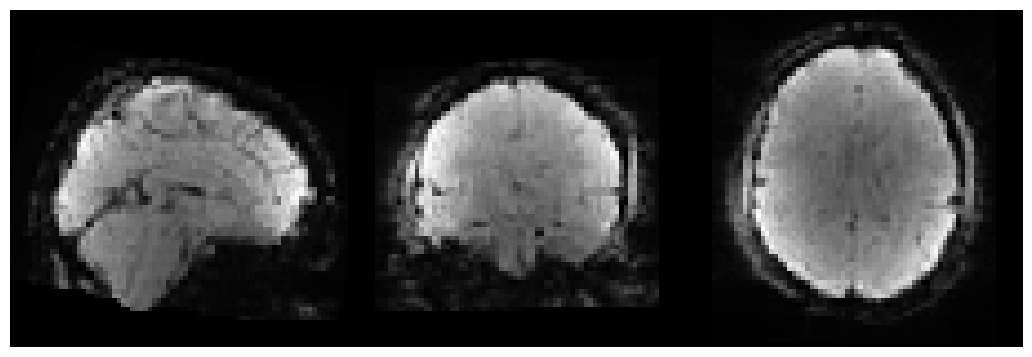

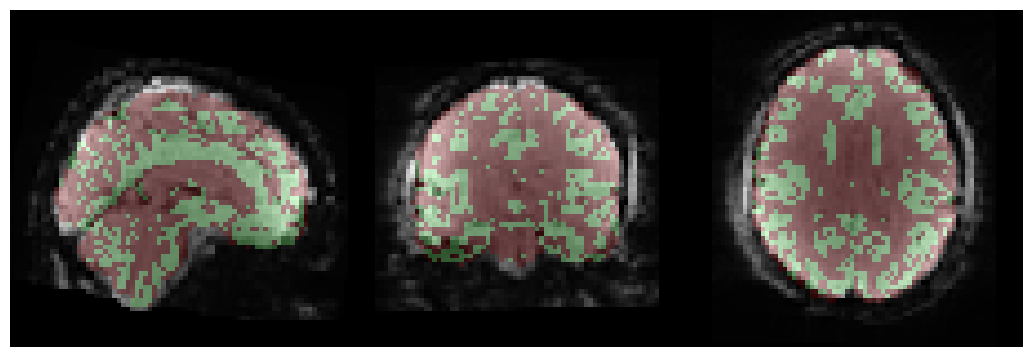

In [42]:
epi_mean = epi.numpy().mean(axis=-1)
temp = gm.new_image_like(epi_mean)
temp.plot_ortho(flat=True,xyz_lines=False,orient_labels=False,figsize=1.5,overlay_alpha=.3)
temp.plot_ortho(gm.new_image_like(gm_mask_c*1.0+cf_mask_c*2.0),flat=True,xyz_lines=False,orient_labels=False,figsize=1.5,overlay_alpha=.3)

In [22]:
#epi_mean = epi.numpy().mean(axis=-1)

In [23]:
# plt.figure(figsize=(15,5))
# plt.subplot(1,3,1)
# mid_s = gm.shape[0]//2
# plt.imshow(np.rot90(gm_mask_c[mid_s,:,:]*-1),cmap='bwr',alpha=.3,vmin=-1,vmax=1)
# plt.imshow(np.rot90(cf_mask_c[mid_s,:,:]*1),cmap='bwr',alpha=.3,vmin=-1,vmax=1)
# plt.imshow(np.rot90(epi_mean[mid_s,:,:]),cmap='gray',alpha=.5)
# plt.xticks([]);plt.yticks([]);

# plt.subplot(1,3,2)
# mid_s = gm.shape[1]//2
# plt.imshow(np.rot90(gm_mask_c[:,mid_s,:]*-1),cmap='bwr',alpha=.3,vmin=-1,vmax=1)
# plt.imshow(np.rot90(cf_mask_c[:,mid_s,:]*1),cmap='bwr',alpha=.3,vmin=-1,vmax=1)
# plt.imshow(np.rot90(epi_mean[:,mid_s,:]),cmap='gray',alpha=.5)
# plt.xticks([]);plt.yticks([]);

# plt.subplot(1,3,3)
# mid_s = gm.shape[2]//2
# plt.imshow(np.rot90(gm_mask_c[:,:,mid_s]*-1),cmap='bwr',alpha=.3,vmin=-1,vmax=1)
# plt.imshow(np.rot90(cf_mask_c[:,:,mid_s]*1),cmap='bwr',alpha=.3,vmin=-1,vmax=1)
# plt.imshow(np.rot90(epi_mean[:,:,mid_s]),cmap='gray',alpha=.5)
# plt.xticks([]);plt.yticks([]);

In [43]:
## Gather their niftis
#epi = ants.image_read(epi_fn) # BOLD data
#gm = ants.image_read(gm_fn) # ROI mask
#cf = ants.image_read(cf_fn) # RONI mask
#brain = ants.image_read(brain_mask.format(sub=sub,r=r)) # Loose brain mask for after training

nt = epi.shape[-1] # Number of timepoints
ndummy = 0 # how many dummy scans to discard

epi_flat = epi.numpy().reshape(-1,nt).transpose() 
epi_flat[0:ndummy,:] = epi_flat[ndummy+1::,:].mean(axis=0) # What to do with dummy scans, set to mean
epi_flat = epi_flat.transpose()
#gm_flat = gm.numpy().flatten().astype(int) # (1082035,)
#cf_flat = cf.numpy().flatten().astype(int) # (1082035,)

gm_flat = gm_mask_c.flatten().astype(int)
cf_flat = cf_mask_c.flatten().astype(int)

assert max(np.unique(cf_flat+gm_flat))!=2, 'overlap' # Assert that voxels in the ROI are NOT in the RONI and vice versa

In [44]:
# np.unique(gm.numpy().flatten()[gm.numpy().flatten()!=0])
# np.unique(cf.numpy().flatten()[cf.numpy().flatten()!=0])

In [45]:
import pandas as pd
#conf_fn = os.path.join(indir,f'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_confounds.tsv')
#conf_fn = os.path.join(indir,f'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_confounds.tsv')
cols = ['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z']
conf_fn = os.path.join(indir,sub,'ses-1','func',f'{sub}_ses-1_task-rest_acq-pedi_run-1_desc-confounds_timeseries.tsv')
df_conf = pd.read_csv(conf_fn,delimiter='\t')
assert np.isnan(df_conf.loc[:,cols].values).sum()==0,'NaNs in motion'
#conf = torch.permute(torch.tensor(df_conf.loc[:,['X','Y','Z','RotX','RotY','RotZ']].values), (1,0))
conf = df_conf.loc[:,cols].values.transpose()
print(df_conf.shape)
df_conf.head()

(947, 2388)


,global_signal,global_signal_derivative1,global_signal_derivative1_power2,global_signal_power2,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,...,motion_outlier04,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12,motion_outlier13
0,2498.037169,NaN,NaN,6.240190e+06,2187.367219,NaN,4.784575e+06,NaN,2489.252294,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2486.983428,-11.053741,122.185200,6.185087e+06,2139.988030,-47.379189,4.579549e+06,2244.787529,2490.465726,1.213433,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2477.940687,-9.042741,81.771163,6.140190e+06,2121.191778,-18.796252,4.499455e+06,353.299089,2486.356594,-4.109132,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2478.426573,0.485886,0.236086,6.142598e+06,2120.145647,-1.046131,4.495018e+06,1.094391,2484.376559,-1.980035,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2473.132420,-5.294153,28.028054,6.116384e+06,2103.357422,-16.788224,4.424112e+06,281.844476,2481.787856,-2.588703,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# Create 3D coordinate grids
x_coords, y_coords, z_coords = np.meshgrid(
np.arange(gm.shape[0]),  # x-coordinates
np.arange(gm.shape[1]),  # y-coordinates
np.arange(gm.shape[2]),  # z-coordinates
indexing="ij"  # "ij" for matrix-style indexing
)
x_coords_flat = x_coords.flatten()
y_coords_flat = y_coords.flatten()
z_coords_flat = z_coords.flatten()

gm_x_coords = x_coords_flat[gm_flat.astype(bool)]
gm_y_coords = y_coords_flat[gm_flat.astype(bool)]
gm_z_coords = z_coords_flat[gm_flat.astype(bool)]
gm_coords = np.stack((gm_x_coords, gm_y_coords, gm_z_coords), axis=-1)

cf_x_coords = x_coords_flat[cf_flat.astype(bool)]
cf_y_coords = y_coords_flat[cf_flat.astype(bool)]
cf_z_coords = z_coords_flat[cf_flat.astype(bool)]
cf_coords = np.stack((cf_x_coords, cf_y_coords, cf_z_coords), axis=-1)

In [47]:
# x,y,z = 30,39,20
# #plt.figure(figsize=(15,5))
# fig, ax = plt.subplots(figsize=(15,5))
# plt.subplot(1,3,1)

# roi_slice = gm.numpy()[:,:,z]
# roni_slice = cf.numpy()[:,:,z]

# roi_slice[roi_slice<.01] = np.nan
# roni_slice[roni_slice<.01] = np.nan
# plt.imshow(roi_slice,cmap='spring')
# plt.imshow(roni_slice,cmap='summer')
# plt.xticks([]);
# plt.yticks([]);

# # plt.subplot(1,3,2)
# # roi_slice = np.rot90(gm.numpy()[:,y,:])
# # roni_slice = np.rot90(cf.numpy()[:,y,:])
# # roi_slice[roi_slice<.01] = np.nan
# # roni_slice[roni_slice<.01] = np.nan
# # plt.imshow(roi_slice,cmap='spring')
# # plt.imshow(roni_slice,cmap='summer')
# # plt.xticks([]);
# # plt.yticks([]);

# # plt.subplot(1,3,3)
# # roi_slice = np.rot90(gm.numpy()[x,:,:])
# # roni_slice = np.rot90(cf.numpy()[x,:,:])
# # roi_slice[roi_slice<.001] = np.nan
# # roni_slice[roni_slice<.001] = np.nan
# # plt.imshow(roi_slice,cmap='spring')
# # plt.imshow(roni_slice,cmap='summer')
# # plt.xticks([]);
# # plt.yticks([]);
# # plt.show()

In [48]:
gm = gm.new_image_like(gm_mask_c*1.0)
cf = gm.new_image_like(cf_mask_c*1.0)

In [49]:
# How many voxels in RONI and ROI
(cf.numpy()==1).sum(),(gm.numpy()==1).sum()

(41992, 24099)

In [50]:
print(epi_flat.shape)
print(sum(gm_flat==1))
print(sum(cf_flat==1))

(311296, 947)
24099
41992


9519


In [51]:
func_gm = epi_flat[gm_flat==1,:] # Data that will be used as the ROI data
func_cf = epi_flat[cf_flat==1,:] # Data that will be used as the RONI data

In [52]:
# func_gm = func_gm-func_gm.mean(axis=0)
# func_cf = func_cf-func_cf.mean(axis=0)

In [53]:
print(func_gm.shape)
print(func_cf.shape)

(24099, 947)
(41992, 947)


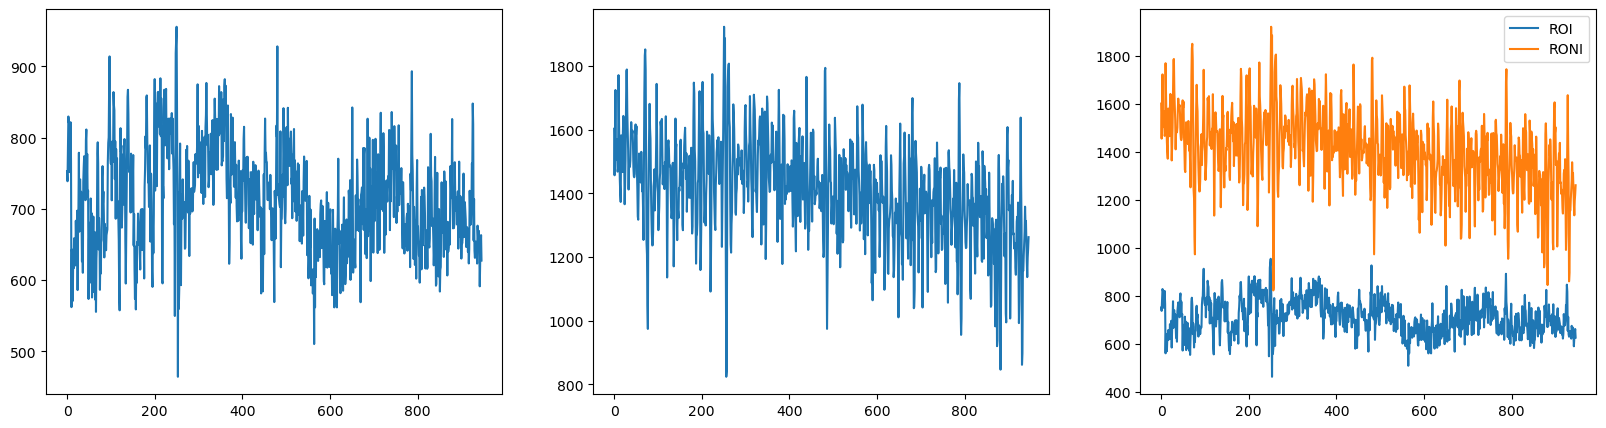

In [54]:
# Plot first voxel in ROI, RONI and both
plt.figure(figsize=(20,5))
plt.subplot(1,3,1);plt.plot(func_gm[0,:])
plt.subplot(1,3,2);plt.plot(func_cf[0,:])
plt.subplot(1,3,3);plt.plot(func_gm[0,:]);plt.plot(func_cf[0,:]);plt.legend(['ROI','RONI'])

In [55]:
print(func_gm.shape)
print(func_cf.shape)

(24099, 947)
(41992, 947)


In [56]:
# #Normalization of Data, remove voxels with std of 0 so it doesnt crash CVAE (from Yu Zhu's code)
# func_gm = remove_std0(func_gm)
# func_cf = remove_std0(func_cf)
# print(func_gm.shape)
# print(func_cf.shape)

In [57]:
# # Apply scaler to ROI and RONI
# obs_scale = Scaler(func_gm)
# obs_list = obs_scale.transform(func_gm)
# print(obs_list.shape)
# noi_scale = Scaler(func_cf)
# noi_list = noi_scale.transform(func_cf)
# print(noi_list.shape)

In [58]:
obs_list = func_gm
noi_list = func_cf

(array([1.7533990e+06, 4.1456140e+06, 1.2275859e+07, 1.2859238e+07,
        6.1410720e+06, 1.9231500e+06, 5.3074700e+05, 1.2755800e+05,
        8.9430000e+03, 8.4400000e+02]),
 array([   0.    ,  751.5035, 1503.007 , 2254.5105, 3006.014 , 3757.5173,
        4509.021 , 5260.5244, 6012.028 , 6763.5312, 7515.0347],
       dtype=float32),
 <BarContainer object of 10 artists>)

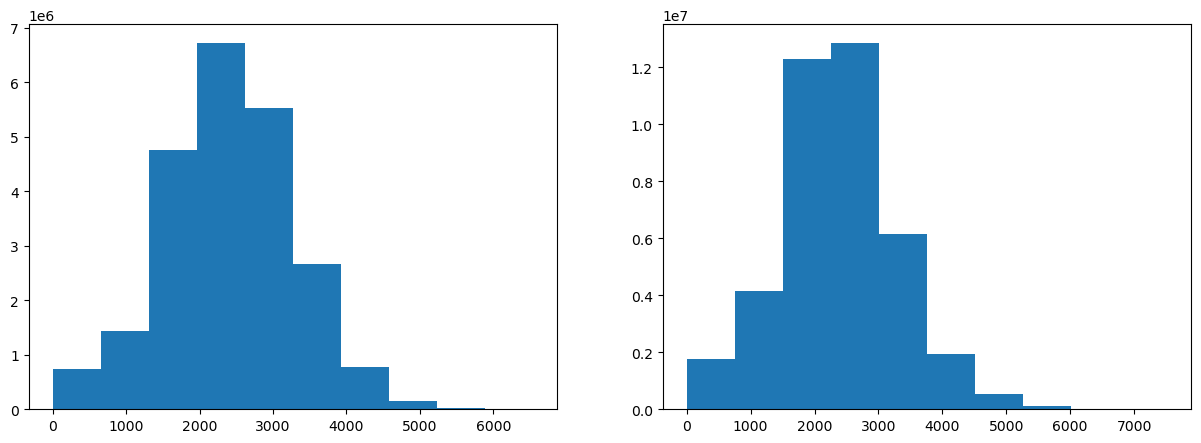

In [59]:
# Plot histograms for ROI and RONI
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(obs_list.flatten())
plt.subplot(1,2,2)
plt.hist(noi_list.flatten())

In [60]:
from torch.autograd import Function
class GradientReversalFunction(Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)  # Pass the input as is

    @staticmethod
    def backward(ctx, grad_output):
        lambda_ = ctx.lambda_
        grad_input = grad_output.neg() * lambda_  # Reverse and scale gradients
        return grad_input, None  # Second element corresponds to lambda_, which has no gradient

class GradientReversalLayer(torch.nn.Module):
    def __init__(self, lambda_=1.0):
        super(GradientReversalLayer, self).__init__()
        self.lambda_ = lambda_

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)


In [61]:
from datetime import datetime
now = datetime.now
t0 = now()

In [62]:
# Normalize coordinates - important for ABIDE
gm_coords = (gm_coords-gm_coords.min(axis=0)) /(gm_coords.max(axis=0)-gm_coords.min(axis=0))
cf_coords = (cf_coords-cf_coords.min(axis=0)) /(cf_coords.max(axis=0)-cf_coords.min(axis=0))

In [63]:
obs_list_coords = np.concatenate([obs_list[:,:,np.newaxis],np.stack([gm_coords for _ in range(nt)],axis=1)],axis=-1)
noi_list_coords = np.concatenate([noi_list[:,:,np.newaxis],np.stack([cf_coords for _ in range(nt)],axis=1)],axis=-1)
obs_list_coords = np.swapaxes(obs_list_coords,1,2)
noi_list_coords = np.swapaxes(noi_list_coords,1,2)

In [64]:
std0_gm = obs_list_coords[:,0,:].std(axis=-1)<1e-3
std0_cf = noi_list_coords[:,0,:].std(axis=-1)<1e-3
print(std0_gm.sum())
print(std0_cf.sum())

print('{}/{}'.format(obs_list_coords.shape[0],noi_list_coords.shape[0]))
obs_list_coords = obs_list_coords[~std0_gm,:,:]
noi_list_coords = noi_list_coords[~std0_cf,:,:]
print('{}/{}'.format(obs_list_coords.shape[0],noi_list_coords.shape[0]))

0
6
24099/41992
24099/41986


In [65]:
# Z score 
obs_list_coords[:,0,:] = (obs_list_coords[:,0,:]-obs_list_coords[:,0,:].mean(axis=1)[:,np.newaxis])/obs_list_coords[:,0,:].std(axis=1)[:,np.newaxis]
noi_list_coords[:,0,:] = (noi_list_coords[:,0,:]-noi_list_coords[:,0,:].mean(axis=1)[:,np.newaxis])/noi_list_coords[:,0,:].std(axis=1)[:,np.newaxis]

In [66]:
# # Scale so it's around -1 to 1
# obs_list_coords[:,0,:] = (obs_list_coords[:,0,:]/abs(obs_list_coords[:,0,:]).max())
# noi_list_coords[:,0,:] = (noi_list_coords[:,0,:]/abs(noi_list_coords[:,0,:]).max())

In [67]:
# obs_list_coords[:,1,:] = (obs_list_coords[:,1,:]-obs_list_coords[:,1,:].mean(axis=1)[:,np.newaxis])/obs_list_coords[:,1,:].std(axis=1)[:,np.newaxis]
# noi_list_coords[:,1,:] = (noi_list_coords[:,1,:]-noi_list_coords[:,1,:].mean(axis=1)[:,np.newaxis])/noi_list_coords[:,1,:].std(axis=1)[:,np.newaxis]
# obs_list_coords[:,2,:] = (obs_list_coords[:,2,:]-obs_list_coords[:,2,:].mean(axis=1)[:,np.newaxis])/obs_list_coords[:,2,:].std(axis=1)[:,np.newaxis]
# noi_list_coords[:,2,:] = (noi_list_coords[:,2,:]-noi_list_coords[:,2,:].mean(axis=1)[:,np.newaxis])/noi_list_coords[:,2,:].std(axis=1)[:,np.newaxis]
# obs_list_coords[:,3,:] = (obs_list_coords[:,3,:]-obs_list_coords[:,3,:].mean(axis=1)[:,np.newaxis])/obs_list_coords[:,3,:].std(axis=1)[:,np.newaxis]
# noi_list_coords[:,3,:] = (noi_list_coords[:,3,:]-noi_list_coords[:,3,:].mean(axis=1)[:,np.newaxis])/noi_list_coords[:,3,:].std(axis=1)[:,np.newaxis]

In [68]:
if obs_list_coords.shape[0]>noi_list_coords.shape[0]:
    n_pad = obs_list_coords.shape[0]-noi_list_coords.shape[0]
    pad_idx = np.random.randint(low=0,high=noi_list_coords.shape[0],size=n_pad)
    noi_list_coords = np.concatenate([noi_list_coords,np.array([noi_list_coords[i,:,:] for i in pad_idx])])
    print(obs_list_coords.shape)
    print(noi_list_coords.shape)

In [69]:
conf[0:3,:] = (conf[0:3,:]-conf[0:3,:].min()) / (conf[0:3,:].max()-conf[0:3,:].min())
conf[3:,:] = (conf[3:,:]-conf[3:,:].min()) / (conf[3:,:].max()-conf[3:,:].min())

In [100]:
def show_bashboard(single_fig=True):

    nrows=5
    ncols=9
    sp=0
    
    if single_fig==True:
        plt.close()
        sys.stdout.flush()
        display.clear_output(wait=True);
        display.display(plt.gcf());
        plt.figure(figsize=(5*ncols,5*nrows))
    
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['l']);plt.title('total loss: {:.2f}'.format(track['l'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['batch_varexp']);plt.title('batch_varexp: {:.2f}'.format(track['batch_varexp'][-1]))
    #sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['varexp']);plt.title('FFA varexp: {:.2f}'.format(track['varexp'][-1]))
    #sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['ffa_io']);plt.title('ffa_io: {:.2f}'.format(track['ffa_io'][-1]))
    
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['recons_loss_roi']);plt.title('recons_loss_roi: {:.2f}'.format(track['recons_loss_roi'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['recons_loss_roni']);plt.title('recons_loss_roni: {:.2f}'.format(track['recons_loss_roni'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['loss_recon_conf_s']);plt.title('loss_recon_conf_s: {:.2f}'.format(track['loss_recon_conf_s'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['kld_loss']);plt.title('kld_loss: {:.2f}'.format(track['kld_loss'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['loss_recon_conf_z']);plt.title('loss_recon_conf_z: {:.2f}'.format(track['loss_recon_conf_z'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['ncc_loss_tg']);plt.title('ncc_loss_tg: {:.2f}'.format(track['ncc_loss_tg'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['ncc_loss_bg']);plt.title('ncc_loss_bg: {:.2f}'.format(track['ncc_loss_bg'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['recons_loss_fg']);plt.title('recons_loss_fg: {:.2f}'.format(track['recons_loss_fg'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['ncc_loss_conf_s']);plt.title('ncc_loss_conf_s: {:.2f}'.format(track['ncc_loss_conf_s'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['ncc_loss_conf_z']);plt.title('ncc_loss_conf_z: {:.2f}'.format(track['ncc_loss_conf_z'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['smoothness_loss']);plt.title('smoothness_loss: {:.2f}'.format(track['smoothness_loss'][-1]))
    

    if single_fig==True:
        sp+=1;plt.subplot(nrows,ncols,sp);
        plt.plot(batch_in[0,0,:])
        plt.plot(batch_out[0,0,:])
        plt.plot(model.forward_bg(inputs_gm)[0].detach().cpu().numpy()[0,0,:],'r-')
        plt.plot(model.forward_fg(inputs_gm)[0].detach().cpu().numpy()[0,0,:],'g-')
        plt.title('batch timecourse (single voxel)')
    
    # sp+=1;plt.subplot(nrows,ncols,sp);
    # plt.plot(ffa_list_coords.mean(axis=0)[0,:])
    # plt.plot(recon.mean(axis=0))
    # plt.title('FFA AVG')
    
    # sp+=1;plt.subplot(nrows,ncols,sp);
    # plt.plot(ffa_list_coords.mean(axis=0)[0,:])
    # plt.plot(signal.mean(axis=0),'g-')
    # plt.plot(face_reg)
    # plt.title('FFA SIGNAL')

    # sp+=1;plt.subplot(nrows,ncols,sp);
    # plt.plot(ffa_list_coords.mean(axis=0)[0,:])
    # plt.plot(noise.mean(axis=0),'r-')
    # plt.plot(face_reg)
    # plt.title('FFA NOISE')

    if single_fig==True:
        sp+=1;plt.subplot(nrows,ncols,sp);
        plt.plot(inputs_cf.detach().cpu().numpy()[0,0,:])
        plt.plot(model.forward_bg(inputs_cf)[0].detach().cpu().numpy()[0,0,:])
        plt.plot(model.forward_fg(inputs_cf)[0].detach().cpu().numpy()[0,0,:])
        plt.title('CF batch voxel')
        
    
    idx = 3
    sp+=1;plt.subplot(nrows,ncols,sp);
    plt.plot(confounds_pred_z[0,idx,:])
    plt.plot(conf[idx,:])
    plt.title('conf from z')
    
    sp+=1;plt.subplot(nrows,ncols,sp);
    plt.plot(confounds_pred_s[0,idx,:])
    plt.plot(conf[idx,:])
    plt.title('conf from s')
    
    sp+=1;plt.subplot(nrows,ncols,sp);
    idx = 2
    plt.plot(batch_in[0:25,idx,0])
    plt.plot(batch_out[0:25,idx,0])
    plt.title('batch coords')
    
    # sp+=1;plt.subplot(nrows,ncols,sp);
    # plt.plot(ffa_list_coords[:,idx,0])
    # plt.plot(recon_coords[:,idx,0])
    # plt.title('FFA coords')
    
    # sp+=1;plt.subplot(nrows,ncols,sp);
    # plt.plot(track['r_ffa_reg'],'k-')
    # plt.plot(track['r_TG_reg'])
    # plt.title('R TG-REG {}'.format(track['r_TG_reg'][-1]))
    
    # sp+=1;plt.subplot(nrows,ncols,sp);
    # plt.plot(track['r_ffa_reg'],'k-')
    # if single_fig==True:
    #     plt.plot(track['r_FG_reg'],'g-')
    # else:
    #     plt.plot(track['r_FG_reg'])
        
    # plt.title('R FG-REG {}'.format(track['r_FG_reg'][-1]))
    
    
    # sp+=1;plt.subplot(nrows,ncols,sp);
    # plt.plot(track['r_ffa_reg'],'k-')
    # plt.plot(track['r_BG_reg'],'r-')
    # plt.title('R BG-REG {}'.format(track['r_BG_reg'][-1]))


    sp+=1;plt.subplot(nrows,ncols,sp);
    plt.hist(bg_mu_z[0,:].detach().cpu().numpy(), bins=10, histtype='step', label='Data 1', linewidth=2)
    plt.hist(tg_mu_z[0,:].detach().cpu().numpy(), bins=10, histtype='step', label='Data 1', linewidth=2)
    plt.hist(tg_mu_s[0,:].detach().cpu().numpy(), bins=10, histtype='step', label='Data 1', linewidth=2)
    plt.legend(['bg_mu_z','tg_mu_z','tg_mu_s'])

    sp+=1;plt.subplot(nrows,ncols,sp);
    plt.hist(np.exp(0.5 * bg_log_var_z[0,:].detach().cpu().numpy()), bins=10, histtype='step', label='Data 1', linewidth=2)
    plt.hist(np.exp(0.5 * tg_log_var_z[0,:].detach().cpu().numpy()), bins=10, histtype='step', label='Data 1', linewidth=2)
    plt.hist(np.exp(0.5 * tg_log_var_s[0,:].detach().cpu().numpy()), bins=10, histtype='step', label='Data 1', linewidth=2)
    plt.legend(['bg_log_var_z','tg_log_var_z','tg_log_var_s'])

    sp+=1;plt.subplot(nrows,ncols,sp);
    plt.plot(track['tg_mu_z'])
    plt.title('tg_mu_z over time')

    sp+=1;plt.subplot(nrows,ncols,sp);
    plt.plot(track['tg_log_var_z'])
    plt.title('tg_log_var_z over time')

    #plt.suptitle(f'E:{epoch} T:{elapsed}',y=.91,fontsize=20)
    if single_fig==True:
        plt.suptitle(f'{sub}-R{r}-rep-{rep} E:{epoch} T:{elapsed}',y=.91,fontsize=20)
        plt.show()

In [71]:
def init_track():
    track = {}
    track['l'] = []
    track['kld_loss'] = []
    track['recons_loss_roi'] = []
    track['recons_loss_roni'] = []
    track['loss_recon_conf_s'] = []
    track['loss_recon_conf_z'] = []
    track['ncc_loss_tg'] = []
    track['ncc_loss_bg'] = []
    track['ncc_loss_conf_s'] = []
    track['ncc_loss_conf_z'] = []
    track['smoothness_loss'] = []
    track['recons_loss_fg'] = []
    track['batch_varexp'] = []
    track['tg_mu_z'] = []
    track['tg_log_var_z'] = []
    track['tg_mu_s'] = []
    track['tg_log_var_s'] = []
    track['tg_z'] = []
    track['tg_s'] = []
    track['bg_log_var_z'] = []
    track['bg_mu_z'] = []
    return track

In [72]:
ofdir_root = '../Data/StudyForrest/ensembles_last_CVAE'
ofdir = os.path.join(ofdir_root,analysis_name)
safe_mkdir(ofdir)
print(ofdir)

../Data/StudyForrest/ensembles_last_CVAE/test-lin


In [73]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [74]:
#len(train_in_coords)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

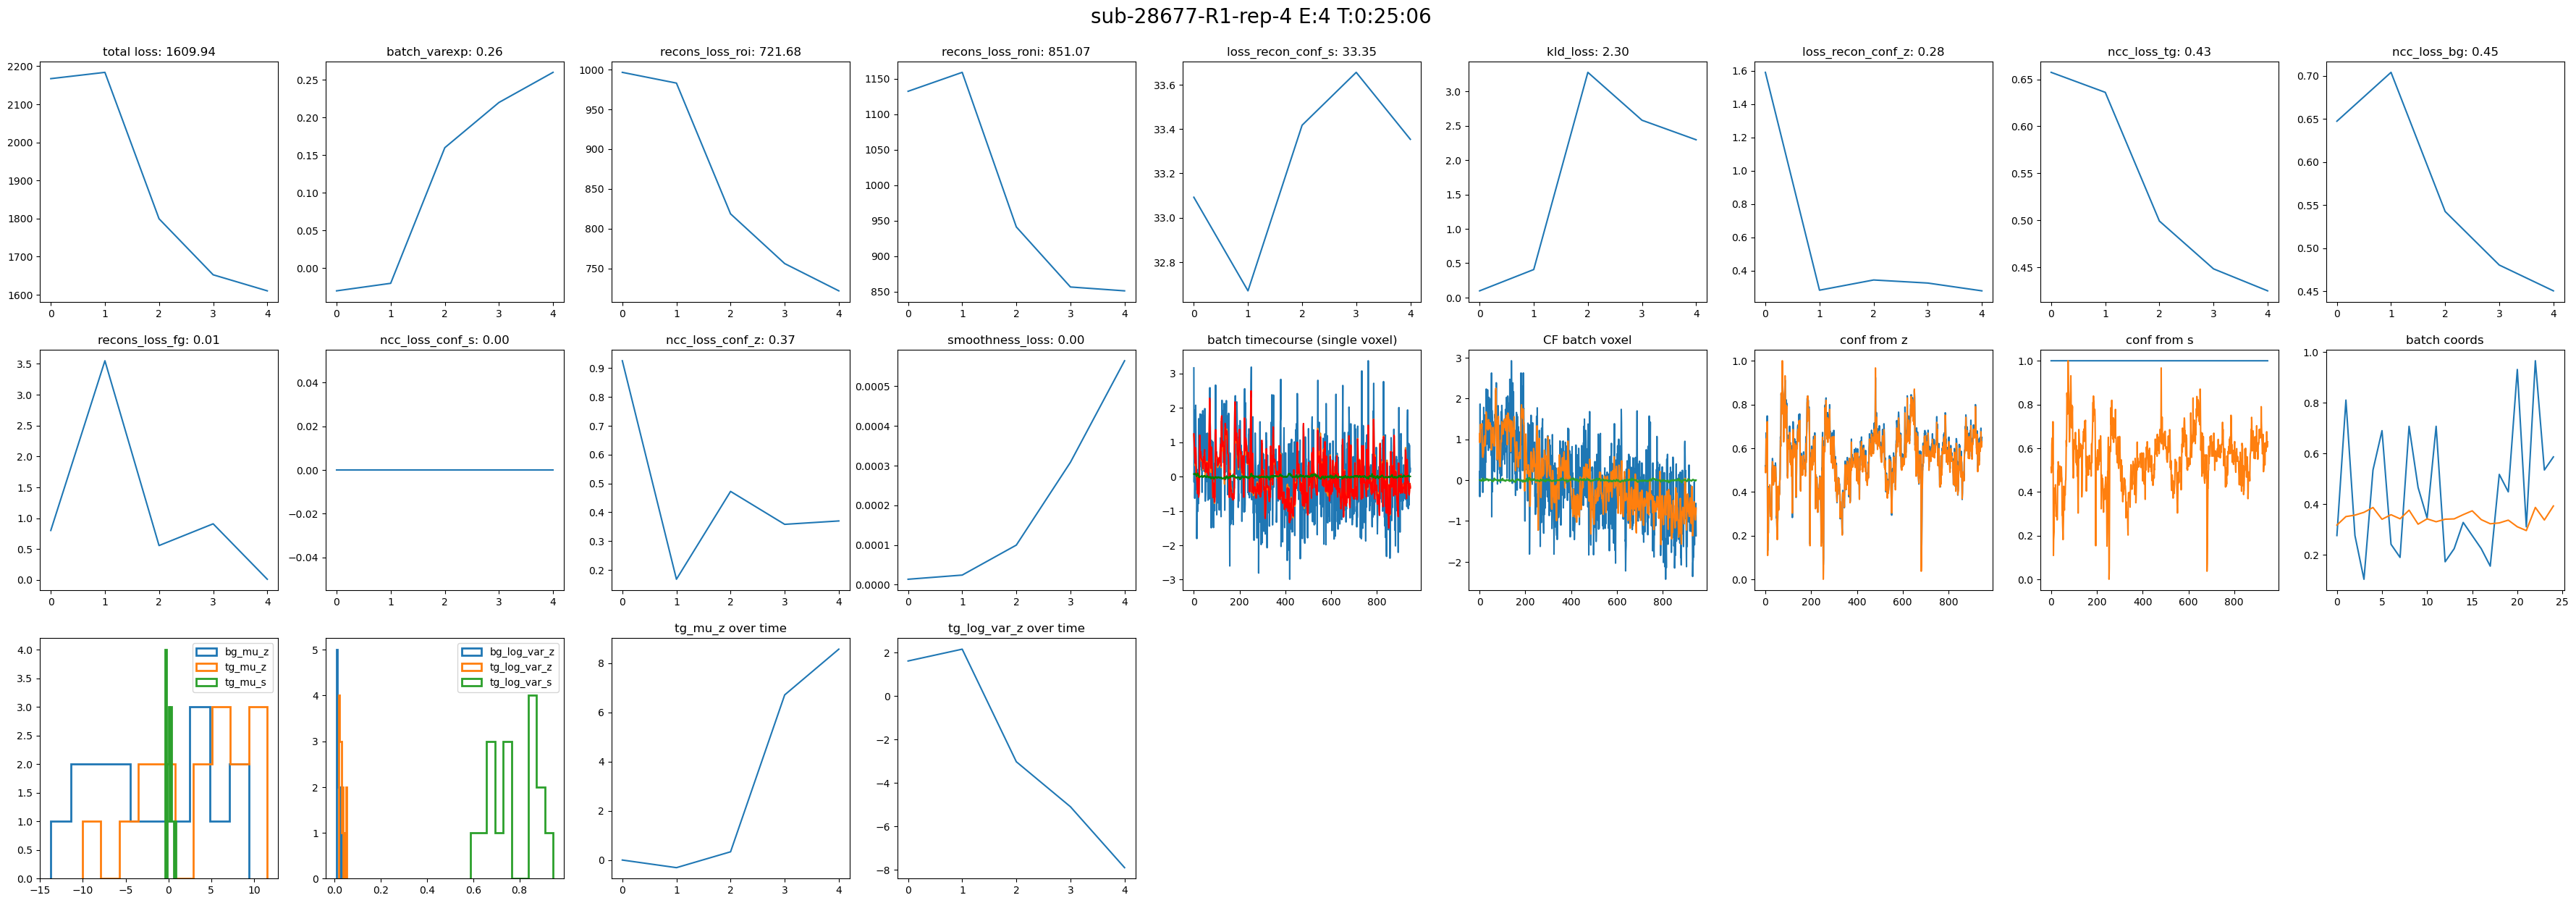

100%|███████████████████████████████████████████| 48/48 [00:02<00:00, 20.80it/s]
Process Process-57:
/data/aglinska/anaconda3/lib/python3.8/tokenize.py:392: ResourceWarning:

unclosed file <_io.BufferedReader name='/data/aglinska/anaconda3/lib/python3.8/multiprocessing/process.py'>



In [90]:
nrep = 10
for rep in range(nrep):
    try:
        ##### Hyperparameters
        batch_size = 512
        #latent_dim = (8,8) # Shared,Specific
        latent_dim = (16,16) # Shared,Specific
        #latent_dim = (12,4) # Shared,Specific
        beta = 0.01       
        gamma = 0 # TC scaling
        delta = 0 # "Denoised RONI should be zero" scaling
        scale_MSE_GM = 1e3 # Scale ROI loss 
        scale_MSE_CF = 1e3 # Scale RONI loss
        scale_MSE_FG = 0 # "Denoised should be similar to input" scaling
        epoch_num = 100
        
        train_inputs_coords = TrainDataset(obs_list_coords,noi_list_coords)
        train_in_coords = torch.utils.data.DataLoader(train_inputs_coords, batch_size=batch_size,shuffle=True, num_workers=1,drop_last=True)
        
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        Tensor = TypeVar('torch.tensor')
        conf_batch = torch.tensor(np.array([conf for _ in range(batch_size)])).to(device)
        model = cVAE(conf_batch,4,func_cf.shape[1],latent_dim, beta=beta, gamma=gamma,delta=delta,scale_MSE_GM=scale_MSE_GM,scale_MSE_CF=scale_MSE_CF,scale_MSE_FG=scale_MSE_FG,freq_exp=0,freq_scale=0,do_disentangle=True)
        model.to(device)
        optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
        track = init_track()
        for epoch in range(epoch_num):  # loop over the dataset multiple times    
            model.train()
            dataloader_iter_in = iter(train_in_coords)
            for i in tqdm(range(len(train_in_coords))):
                optimizer.zero_grad()
                inputs_gm,inputs_cf = next(dataloader_iter_in)
        
                inputs_gm = inputs_gm.float().to(device)
                inputs_cf = inputs_cf.float().to(device)
            
                [outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s] = model.forward_tg(inputs_gm)
                [outputs_cf, inputs_cf, bg_mu_z, bg_log_var_z] = model.forward_bg(inputs_cf)
                
                loss = model.loss_function(outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s, outputs_cf, inputs_cf, bg_mu_z, bg_log_var_z)
            
                if np.isnan(loss['loss'].detach().cpu().numpy()):
                    print('loss is NaN')
                    break
            
                loss['loss'].backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # Prevent gradient explosion
                optimizer.step()
        
        
            if np.mod(epoch,1)==0:
                model.eval()
            
                confounds_pred_z = model.decoder_confounds_z(torch.unsqueeze(tg_z,2)).detach().cpu().numpy()
                confounds_pred_s = model.decoder_confounds_s(torch.unsqueeze(tg_s,2)).detach().cpu().numpy()
                
                batch_signal = model.forward_fg(inputs_gm)[0].detach().cpu().numpy()
                batch_noise = model.forward_bg(inputs_gm)[0].detach().cpu().numpy()
                
                batch_in = inputs_gm.detach().cpu().numpy()
                batch_out = outputs_gm.detach().cpu().numpy()
                
                batch_SST = ((batch_in[:,0,:]-batch_in[:,0,:].mean(axis=0))**2).sum()
                batch_SSM = ((batch_in[:,0,:]-batch_out[:,0,:])**2).sum()
                batch_varexp = (1-batch_SSM/batch_SST).round(2)
                        
                l = loss['loss'].detach().cpu().numpy()
                kld_loss = loss['kld_loss'].detach().cpu().numpy()
                recons_loss_roi = loss['recons_loss_roi'].detach().cpu().numpy()
                recons_loss_roni = loss['recons_loss_roni'].detach().cpu().numpy()
                loss_recon_conf_s = loss['loss_recon_conf_s'].detach().cpu().numpy()
                loss_recon_conf_z = loss['loss_recon_conf_z'].detach().cpu().numpy()
                ncc_loss_tg = loss['ncc_loss_tg'].detach().cpu().numpy()
                ncc_loss_bg = loss['ncc_loss_bg'].detach().cpu().numpy()
                ncc_loss_conf_s = loss['ncc_loss_conf_s'].detach().cpu().numpy()
                ncc_loss_conf_z = loss['ncc_loss_conf_z'].detach().cpu().numpy()
                smoothness_loss = loss['smoothness_loss'].detach().cpu().numpy()
                recons_loss_fg = loss['recons_loss_fg'].detach().cpu().numpy()
                
                        
                elapsed = str(now()-t0).split('.')[0]
        
                track['batch_varexp'].append(batch_varexp)
                track['l'].append(float(l))
                track['kld_loss'].append(float(kld_loss))
                track['recons_loss_roi'].append(float(recons_loss_roi))
                track['recons_loss_roni'].append(float(recons_loss_roni))
                track['loss_recon_conf_s'].append(float(loss_recon_conf_s))
                track['loss_recon_conf_z'].append(float(loss_recon_conf_z))
                track['ncc_loss_tg'].append(float(ncc_loss_tg))
                track['ncc_loss_bg'].append(float(ncc_loss_bg))
                track['ncc_loss_conf_s'].append(float(ncc_loss_conf_s))
                track['ncc_loss_conf_z'].append(float(ncc_loss_conf_z))
                track['smoothness_loss'].append(float(smoothness_loss))
                track['recons_loss_fg'].append(float(recons_loss_fg))
                track['tg_mu_z'].append( tg_mu_z.detach().cpu().numpy()[0,0] )
                track['tg_log_var_z'].append( tg_log_var_z.detach().cpu().numpy()[0,0] )
                track['tg_mu_s'].append( tg_mu_s.detach().cpu().numpy()[0,0] )
                track['tg_log_var_s'].append( tg_log_var_s.detach().cpu().numpy()[0,0] )
                track['tg_z'].append( tg_z.detach().cpu().numpy()[0,0] )
                track['tg_s'].append( tg_s.detach().cpu().numpy()[0,0] )
                track['bg_log_var_z'].append( bg_log_var_z.detach().cpu().numpy()[0,0] )
                track['bg_mu_z'].append( bg_mu_z.detach().cpu().numpy()[0,0] )
            
                if len(track['batch_varexp'])>100:
                    track['batch_varexp'] = track['batch_varexp'][1::]
                    track['l'] = track['l'][1::]
                    track['kld_loss'] = track['kld_loss'][1::]
                    track['recons_loss_roi'] = track['recons_loss_roi'][1::]
                    track['recons_loss_roni'] = track['recons_loss_roni'][1::]
                    track['loss_recon_conf_s'] = track['loss_recon_conf_s'][1::]
                    track['loss_recon_conf_z'] = track['loss_recon_conf_z'][1::]
                    track['ncc_loss_tg'] = track['ncc_loss_tg'][1::]
                    track['ncc_loss_bg'] = track['ncc_loss_bg'][1::]
                    track['ncc_loss_conf_s'] = track['ncc_loss_conf_s'][1::]
                    track['ncc_loss_conf_z'] = track['ncc_loss_conf_z'][1::]
                    track['smoothness_loss'] = track['smoothness_loss'][1::]
                    track['recons_loss_fg'] = track['recons_loss_fg'][1::]
                    track['tg_mu_z'] = track['tg_mu_z'][1::]
                    track['tg_log_var_z'] = track['tg_log_var_z'][1::]
                    track['tg_mu_s'] = track['tg_mu_s'][1::]
                    track['tg_log_var_s'] = track['tg_log_var_s'][1::]
                    track['tg_z'] = track['tg_z'][1::]
                    track['tg_s'] = track['tg_s'][1::]
                    track['bg_log_var_z'] = track['bg_log_var_z'][1::]
                    track['bg_mu_z'] = track['bg_mu_z'][1::]
            
                show_bashboard()
        
        
        
        track_ofn = os.path.join(ofdir,f'track_S{s}_R{r}_rep_{rep}.pickle')
        model_ofn = os.path.join(ofdir,f'model_S{s}_R{r}_rep_{rep}.pickle')
        
        with open(track_ofn, 'wb') as handle:
            pickle.dump(track, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'loss': loss, 
        }, model_ofn)
        
        
        model.eval()
        train_in_coords = torch.utils.data.DataLoader(train_inputs_coords, batch_size=batch_size,shuffle=False, num_workers=1,drop_last=False)
        dataloader_iter_in = iter(train_in_coords)
        brain_signals=[]
        for i in tqdm(range(len(dataloader_iter_in))):
            inputs_gm,inputs_cf = next(dataloader_iter_in)
            inputs_gm = inputs_gm.float().to(device)
            #inputs_cf = inputs_cf.float().to(device)
            brain_signals.append(model.forward_fg(inputs_gm)[0].detach().cpu().numpy()[:,0,:])
        
        brain_signals_arr = np.zeros(epi_flat.shape)
        #brain_signals_arr[gm_flat==1,:][std0_gm==False,:] = np.vstack(brain_signals)
        #brain_signals_arr[gm_flat==1,:] = np.vstack(brain_signals)
        brain_signals_arr[(gm_flat==1) * (epi_flat.std(axis=1)>1e-3),:] = np.vstack(brain_signals)
        brain_signals_arr = brain_signals_arr.reshape(epi.shape)
        brain_signals_arr = epi.new_image_like(brain_signals_arr)
        
        signal_ofn = os.path.join(ofdir,f'signal_S{s}_R{r}_rep_{rep}.nii.gz')
        brain_signals_arr.to_filename(signal_ofn)
    except:
        pass

In [96]:
output_files = [os.path.join(ofdir,val) for val in os.listdir(ofdir) if val.startswith(f'signal_S{s}_R{r}_') ]
track_files = [os.path.join(ofdir,val) for val in os.listdir(ofdir) if val.startswith(f'track_S{s}_R{r}_') ]

output_files.sort()
track_files.sort()
print(f'{len(output_files)}/{len(track_files)}')

5/5


In [97]:
def load_pickle(fn):
    if os.path.exists(fn):
        with open(fn, 'rb') as file:
            loaded_dict = pickle.load(file)
    return loaded_dict

In [107]:
#outputs = [load_pickle(output_file) for output_file in output_files]
tracks = [load_pickle(track_file) for track_file in track_files]

In [127]:
signals = [ants.image_read(output_file) for output_file in output_files]

In [128]:
signals_arr = np.array([signal.numpy() for signal in signals])
signals_arr.shape

In [167]:
signals_arr_flat = np.array([signal_arr.reshape(-1,nt) for signal_arr in signals_arr])

In [ ]:
del signals
del signals_arr

In [209]:
std0_v2 = epi_flat.std(axis=1)<1e-3

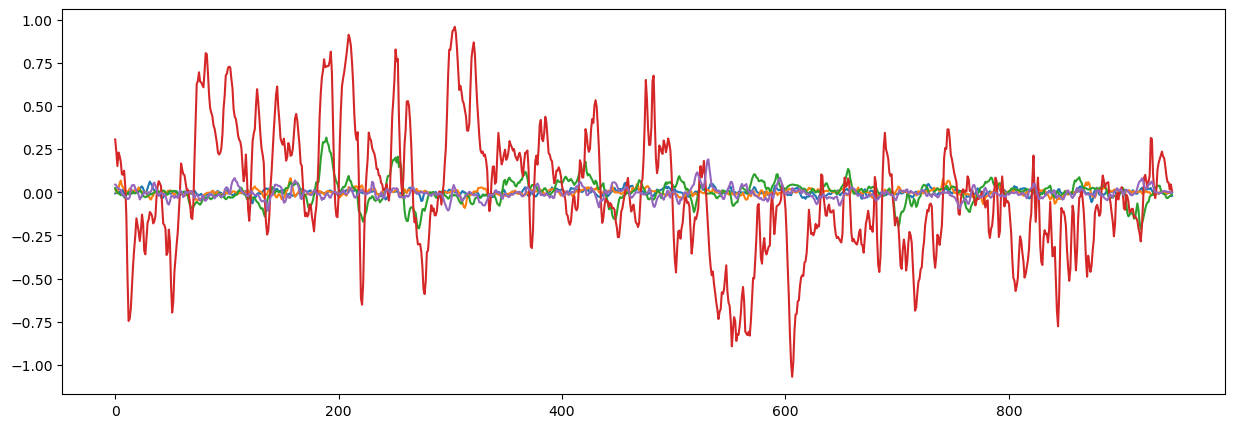

In [249]:
gm_idx = 12000
plt.figure(figsize=(15,5))
#plt.plot(obs_list_coords[gm_idx,0,:],'k-')
for i in range(signals_arr_flat.shape[0]):
    plt.plot(signals_arr_flat[i,((gm_flat==1) * (std0_v2==0)),:][gm_idx,:])

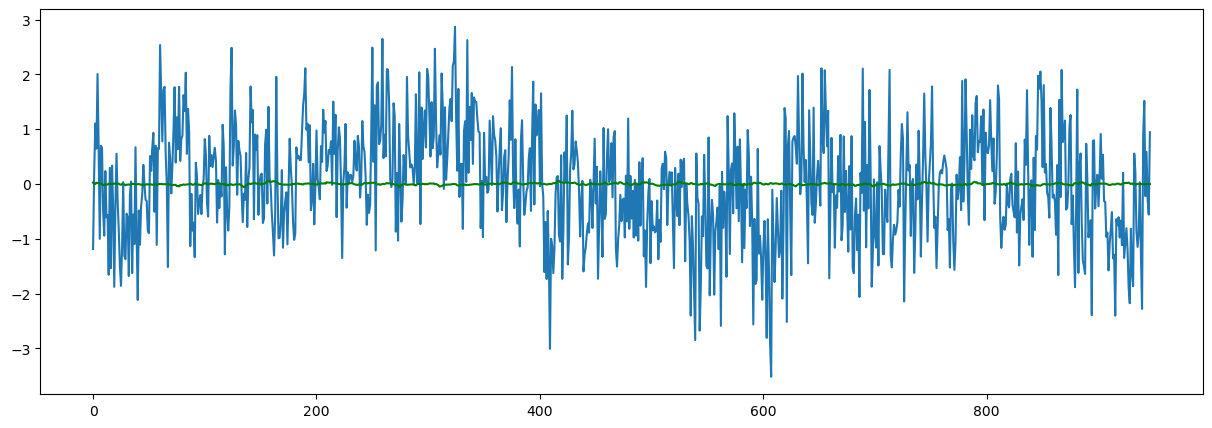

In [250]:
#gm_idx = 6000
plt.figure(figsize=(15,5))
plt.plot(obs_list_coords[gm_idx,0,:])
plt.plot(np.median(signals_arr_flat[:,((gm_flat==1) * (std0_v2==0)),:][:,gm_idx,:],axis=0),'g-')

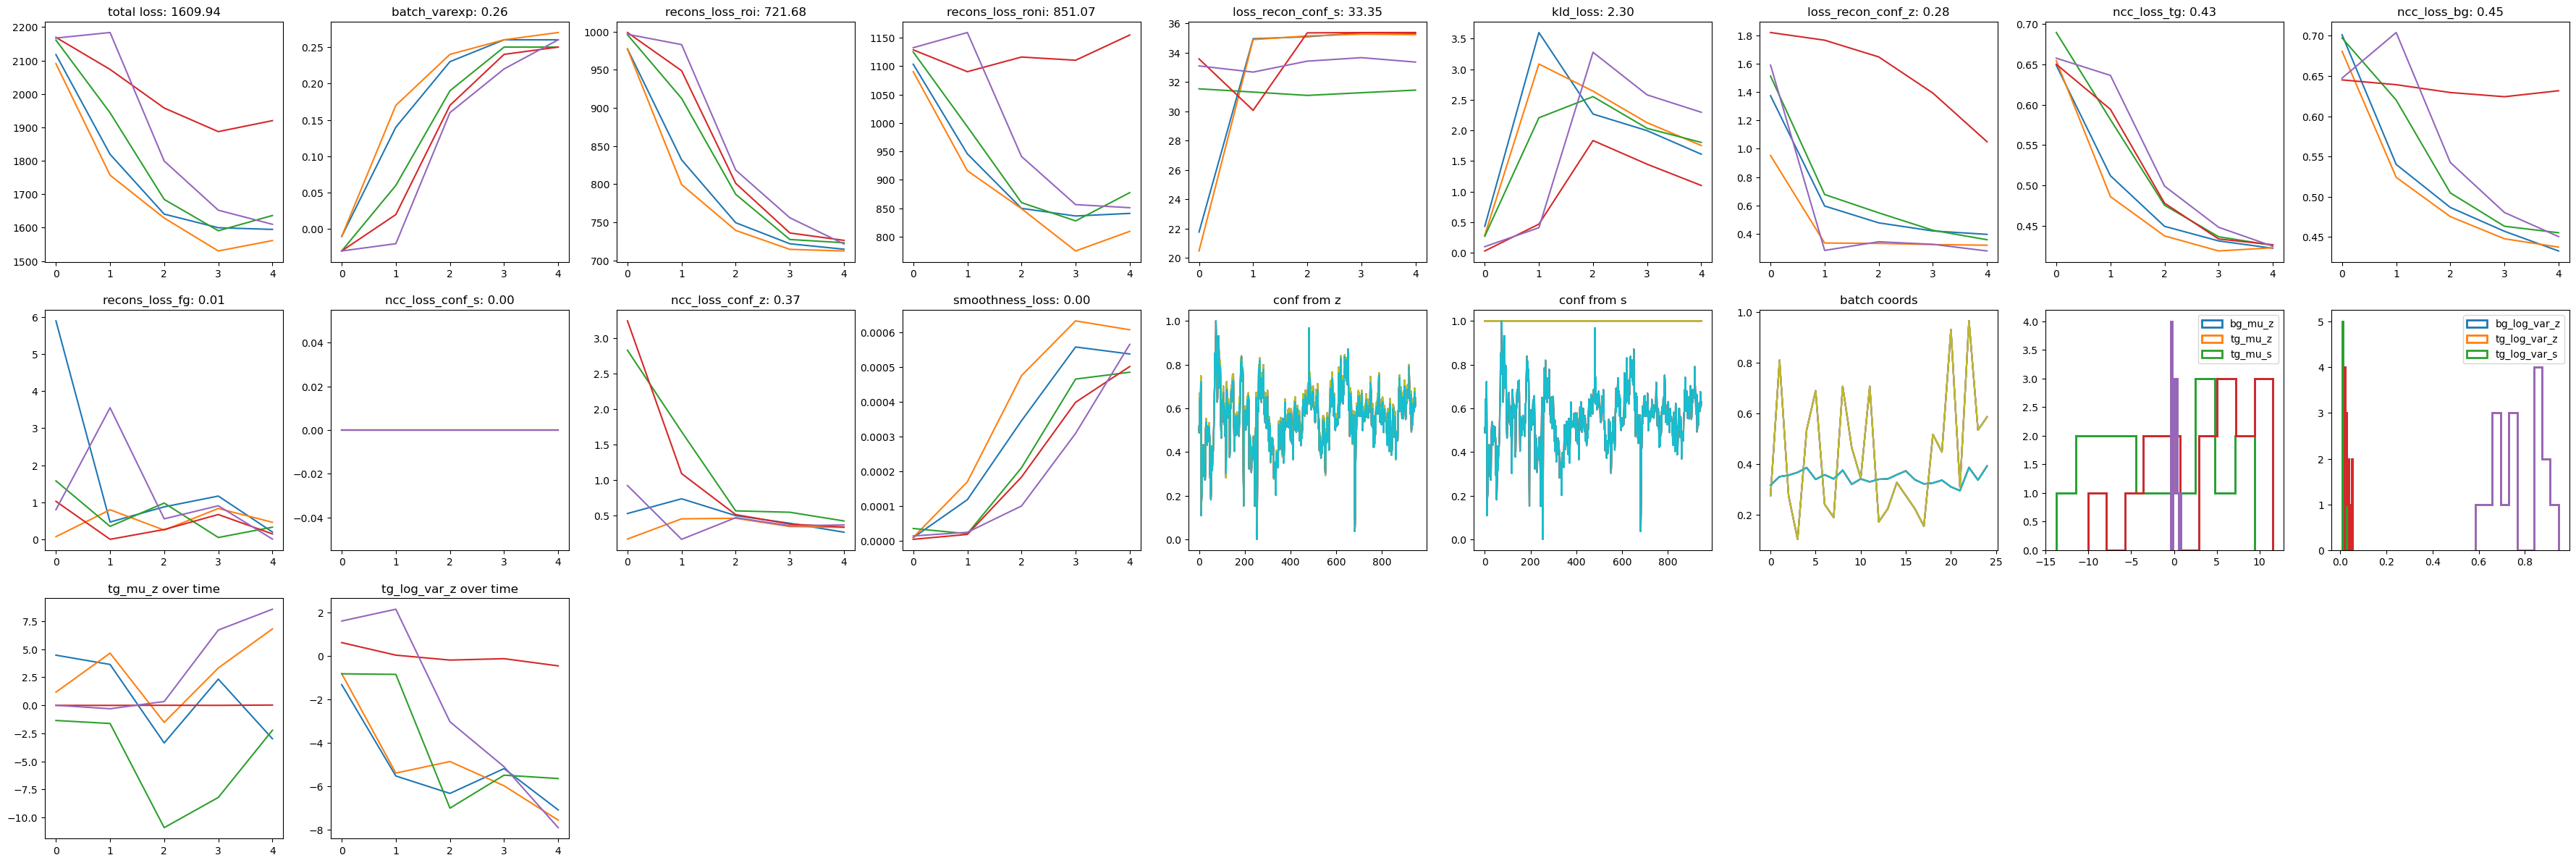

In [109]:
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(5*9,5*5))
for track in tracks:
    show_bashboard(single_fig=False)